# Likelihood test

In [1]:
import copy
import jax 
print(f"GPU found? {jax.devices()}")
import jax.numpy as jnp
import numpy as np

from fiesta.inference.lightcurve_model import BullaLightcurveModel
from fiesta.inference.likelihood import EMLikelihood
from fiesta.inference.prior import Uniform, Composite
from fiesta.inference.injection import InjectionRecovery
from fiesta.utils import load_event_data

import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

GPU found? [CudaDevice(id=0)]


Preamble

In [2]:
filters = ["ps1__g", "ps1__r", "ps1__i", "ps1__z", "ps1__y", "2massj", "2massh", "2massks", "sdssu"]
# trigger_time = 57982.5285236896 # TODO: needed for AT2017gfo, remove?
trigger_time = 0.0 

In [3]:
def nice_plot():
    pass

## Load the model

In [4]:
## Load the Bulla model and data
model = BullaLightcurveModel("Bu2022Ye",
                             "../trained_models/Bu2022Ye/",
                             filters)

2024-08-06 12:42:50.082038: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Create an injection

In [5]:
injection_dict = {"KNtheta": jnp.pi / 4,
                  "log10_mej_dyn": -2.5,
                  "vej_dyn": 0.15,
                  "Yedyn": 0.25,
                  "log10_mej_wind": -1.5,
                  "vej_wind": 0.1,
                  "luminosity_distance": 44.0,}

injection = InjectionRecovery(model, 
                              filters,
                              injection_dict,
                              randomize_nondetections=True)

injection.create_injection()

print("injection.data example")
print(injection.data[filters[0]])

print("shape of injection.data")
print(np.shape(injection.data[filters[0]]))

injection.data example
[[ 0.1        19.82460783  1.        ]
 [ 1.64444444 20.44383791  1.        ]
 [ 3.18888889 23.97484429  1.        ]
 [ 4.73333333 26.80807931  1.        ]
 [ 6.27777778 27.82901995         inf]
 [ 7.82222222 33.31812981  1.        ]
 [ 9.36666667 35.81188755  1.        ]
 [10.91111111 39.202695    1.        ]
 [12.45555556 40.28758946         inf]
 [14.         43.77586073  1.        ]]
shape of injection.data
(10, 3)


Plot the injection

idx_det
[0 1 2 3 5 6 7 9]
idx_nondet
[4 8]
idx_det
[1 3 4 5 6 7 8 9]
idx_nondet
[0 2]
idx_det
[1 2 3 5 6 7 8 9]
idx_nondet
[0 4]
idx_det
[1 2 3 4 5 7 8 9]
idx_nondet
[0 6]
idx_det
[0 1 3 5 6 7 8 9]
idx_nondet
[2 4]
idx_det
[0 2 3 4 5 6 7 8]
idx_nondet
[1 9]
idx_det
[0 1 2 3 5 6 7 8]
idx_nondet
[4 9]
idx_det
[0 2 3 5 6 7 8 9]
idx_nondet
[1 4]
idx_det
[0 1 2 3 5 6 7 8]
idx_nondet
[4 9]


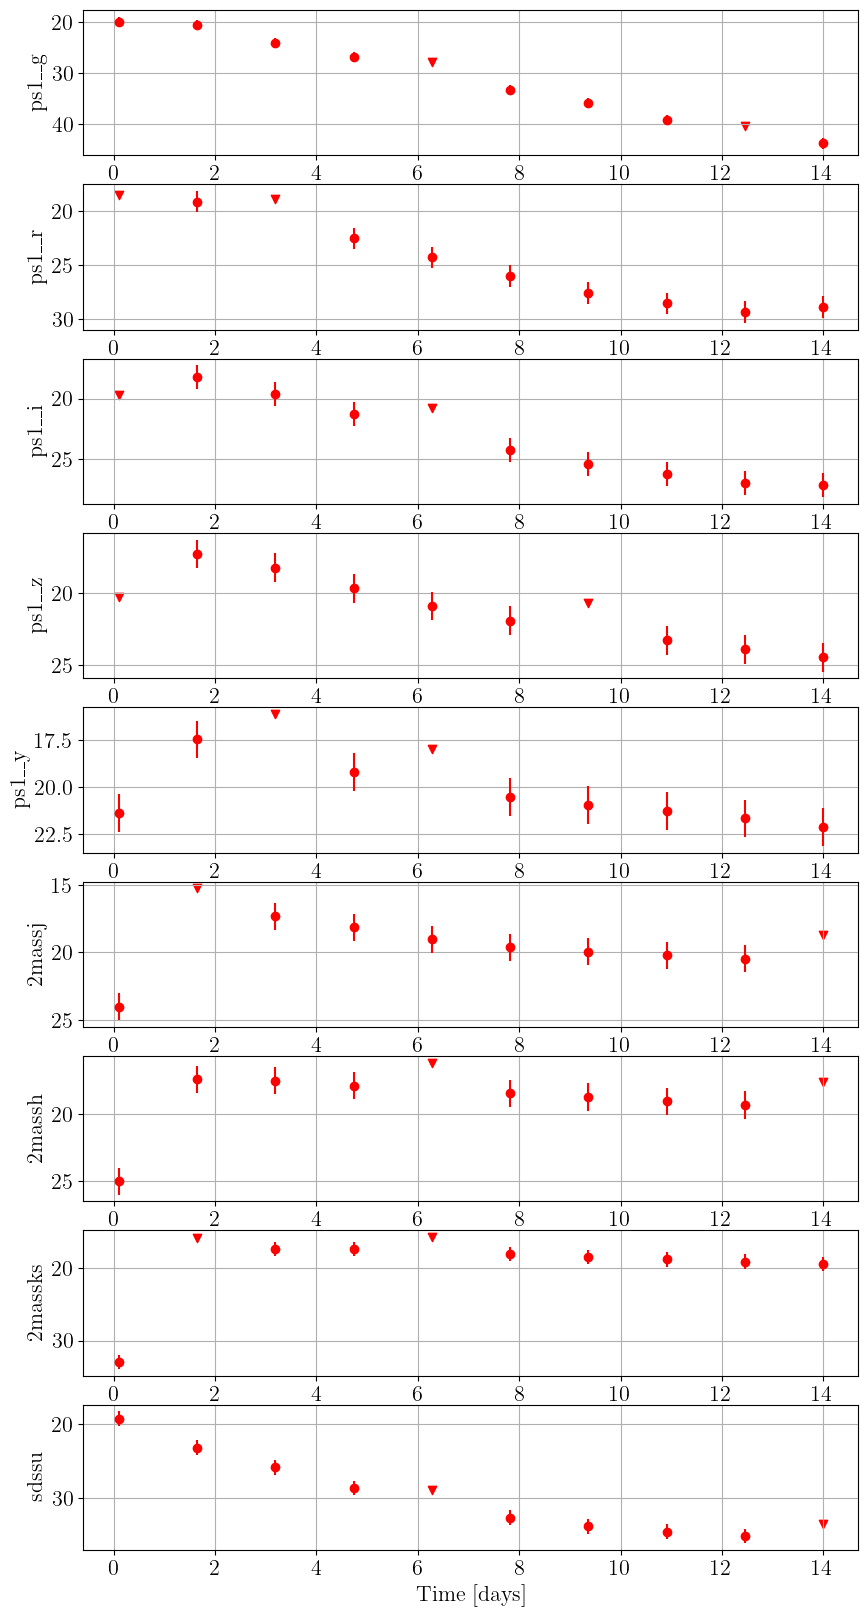

In [12]:
fig, ax = plt.subplots(nrows = len(filters), ncols = 1, figsize = (10, 20))

for i, filter_name in enumerate(filters):
    ax = plt.subplot(len(filters), 1, i + 1)
    
    # Load the data
    t, mag, err = injection.data[filter_name].T
    idx_det = np.where(err != np.inf)[0]
    idx_nondet = np.where(err == np.inf)[0]
    
    # ### Plot the data
    # ax.plot(t, mag, color = "blue", label = "Model")
    
    # Detections
    ax.errorbar(t[idx_det] - trigger_time, mag[idx_det], yerr = err[idx_det], fmt = "o", color = "red", label = "Data (det.)")
    
    # Non-detections
    ax.scatter(t[idx_nondet] - trigger_time, mag[idx_nondet], marker = "v", color = "red", label = "Data (nondet.)")
    
    # Make pretty
    ax.set_xlabel("Time [days]")
    ax.set_ylabel(filter_name)
    ax.invert_yaxis()
    
plt.show()

## Priors and likelihood objects initialization

In [13]:
inclination_EM      = Uniform(xmin=0.0, xmax=jnp.pi/2., naming=['KNtheta'])
log10_mej_dyn       = Uniform(xmin=-3.0, xmax=-1.7, naming=['log10_mej_dyn'])
vej_dyn             = Uniform(xmin=0.12, xmax=0.25, naming=['vej_dyn'])
Yedyn               = Uniform(xmin=0.15, xmax=0.3, naming=['Yedyn'])
log10_mej_wind      = Uniform(xmin=-2.0, xmax=-0.89, naming=['log10_mej_wind'])
vej_wind            = Uniform(xmin=0.03, xmax=0.15, naming=['vej_wind'])

prior_list = [inclination_EM, 
              log10_mej_dyn, 
              vej_dyn, 
              Yedyn, 
              log10_mej_wind, 
              vej_wind]

prior = Composite(prior_list)

likelihood = EMLikelihood(model,
                          filters,
                          injection.data,
                          fixed_params={"luminosity_distance": 44.0},
                          trigger_time=trigger_time)

Converting error budget to dictionary.
NOTE: No detection limit is given. Putting it to infinity.
Loading and preprocessing observations in likelihood . . .


## Single evaluation test:

In [17]:
# log_likelihood = jax.jit(likelihood.evaluate)
log_likelihood = likelihood.evaluate

# Generate a new sample
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
samples = prior.sample(subkey, 1)
samples = {key: float(v[0]) for key, v in samples.items()}

print("samples")
print(samples)

# Get the log prob
value = log_likelihood(samples)
print("value")
print(value)

samples
{'KNtheta': 1.332985177184185, 'log10_mej_dyn': -2.4738706737926313, 'vej_dyn': 0.1976104851169566, 'Yedyn': 0.20195160425155803, 'log10_mej_wind': -1.2362076636931203, 'vej_wind': 0.12298144546238514}
chisq_total
-97.24847970817481
gaussprob_total
-4.114817999976518
value
-101.36329770815134


## Likelihood profiling

In [15]:
# Get the masses array
for i in range(len(prior_list)):
    print(f"i: {i / len(prior_list)}")
    for j in range(i + 1, len(prior_list)):
        print(f"j: {j / len(prior_list)}")
        idx_1 = i
        idx_2 = j
        
        N = 20
        log_likelihood = jax.jit(likelihood.evaluate)
        
        xmin_1, xmax_1 = prior_list[idx_1].xmin, prior_list[idx_1].xmax
        xmin_2, xmax_2 = prior_list[idx_2].xmin, prior_list[idx_2].xmax

        name_1 = prior_list[idx_1].naming[0]
        name_2 = prior_list[idx_2].naming[0]

        params_1_array = jnp.linspace(xmin_1, xmax_1, N)
        params_2_array = jnp.linspace(xmin_2, xmax_2, N)
        P1, P2 = jnp.meshgrid(params_1_array, params_2_array)

        P1 = P1.reshape(-1)
        P2 = P2.reshape(-1)

        ll_array = []
        for p1, p2 in zip(P1, P2):
            params = copy.deepcopy(injection_dict)
            params[name_1] = p1
            params[name_2] = p2
            ll = log_likelihood(params)
            ll_array.append(ll)
            
        # Reshape
        P1_reshaped = P1.reshape(len(params_1_array), len(params_2_array))
        P2_reshaped = P2.reshape(len(params_1_array), len(params_2_array))
        ll_array_reshaped = jnp.array(ll_array).reshape(len(params_1_array), len(params_2_array))

        plt.contourf(P1_reshaped, P2_reshaped, ll_array_reshaped, levels=20)
        plt.axvline(injection_dict[name_1], color="red")
        plt.axhline(injection_dict[name_2], color="red")
        plt.xlabel(name_1)
        plt.ylabel(name_2)
        plt.colorbar()
        plt.grid(False)
        plt.savefig(f"./figures/likelihood_profiling_test_{name_1}_{name_2}.png")
        plt.close()

i: 0.0
j: 0.16666666666666666
j: 0.3333333333333333
j: 0.5
j: 0.6666666666666666
j: 0.8333333333333334
i: 0.16666666666666666
j: 0.3333333333333333
j: 0.5
j: 0.6666666666666666
j: 0.8333333333333334
i: 0.3333333333333333
j: 0.5
j: 0.6666666666666666
j: 0.8333333333333334
i: 0.5
j: 0.6666666666666666
j: 0.8333333333333334
i: 0.6666666666666666
j: 0.8333333333333334
i: 0.8333333333333334
